In [1]:
# pandas_datareaderをインストール
# !pip install pandas_datareader

In [37]:
# ライブラリのインポート
from datetime import datetime, timedelta
import talib as ta
import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import seaborn as sns
%matplotlib inline

# 必要な関数を定義
'''
データの取り込みと調整を行う関数
'''
def import_data(kind, reference='yahoo'):
    data_master = data.DataReader(kind, reference, '2000-01-01', end)
    data_master.reset_index(drop=False, inplace=True)
    data_master['Date'] = pd.to_datetime(data_master['Date'])
    return data_master

'''
テクニカル指標のロジック番号を作成する関数
'''
def create_logic_number(n):
    n += 1
    logic = 'logic' + str('{0:05d}'.format(n))
    return n, logic

'''
テクニカル指標についてのデータを追加する関数
'''
def append_logic(data_logic, data_graph, list_logic, list_graph):
    data_logic = pd.concat([data_logic, pd.DataFrame(list_logic).T])
    data_graph.append(list_graph)
    return data_logic, data_graph

'''
テクニカル指標を導入する関数
'''
def data_arrange(data_master):
    # 警告が出ないようにコピーしたデータフレームを使う
    data_technical = data_master.copy()
    # ロジックについての配列を作成
    data_logic = pd.DataFrame()
    data_graph = []
    # テクニカル指標を作成するカラムを指定して変数sに格納
    s = data_technical['Close']
    # for文を使ってテクニカル指標を新たに作成
    for i in windows:
        # 単純移動平均
        data_technical['sma_' + str(i)] = s.rolling(window=i).mean()
        # 指数移動平均
        data_technical['ema_' + str(i)] = s.ewm(span=i).mean()
        # ボリンジャーバンド
        for j in deviation:
            # upper_sigma
            data_technical['upper_' + str(i) + '_dev_' + str(j)] = data_technical['sma_' + str(i)] + s.rolling(window=i).std(ddof=0) * j
            #lower_sigma
            data_technical['lower_' + str(i) + '_dev_' + str(j)] = data_technical['sma_' + str(i)] - s.rolling(window=i).std(ddof=0) * j

            # ボリンジャーバンドの上か下か
            data_technical['upper_check' + str(i) + '_dev_' + str(j)] = s >= data_technical['upper_' + str(i) + '_dev_' + str(j)]
            data_technical['lower_check' + str(i) + '_dev_' + str(j)] = s <= data_technical['lower_' + str(i) + '_dev_' + str(j)]
    for r in rsi_windows:
        # rsi
        data_technical['rsi_' + str(r)] = ta.RSI(s, timeperiod=r)
    
    # 実体
    data_technical['entity'] = abs(data_technical['Open'] - data_technical['Close'])
	# ローソクの長さ
    data_technical['size'] = data_technical['High'] - data_technical['Low']
    # True＝陽
    data_technical['陽陰'] = data_technical['Close'] > data_technical['Open']
    # 上ヒゲの長さ
    data_technical['upper_hige'] = data_technical.apply(lambda x: (x['High'] - x['Close']) if x['Close'] >= x['Open'] else (x['High'] - x['Open']),axis=1)
    # 下ヒゲの長さ
    data_technical['lower_hige'] = data_technical.apply(lambda x: (x['Open'] - x['Low'] ) if x['Close'] >= x['Open'] else (x['Close'] - x['Low']),axis=1)
    # 上ヒゲ、実体、下ヒゲのpercentage
    data_technical['upper_size'] = data_technical['upper_hige'] / data_technical['size']
    data_technical['entity_seze'] = data_technical['entity'] / data_technical['size']
    data_technical['lower_size'] = data_technical['lower_hige'] / data_technical['size']

    # DMの計算
    pos_DM = (data_technical['High'] - data_technical['High'].shift(1))
    neg_DM = (data_technical['Low'].shift(1) - data_technical['Low'])
    pos_DM.loc[pos_DM < 0] = 0
    pos_DM.loc[pos_DM - neg_DM < 0] = 0
    neg_DM.loc[neg_DM < 0] = 0
    neg_DM.loc[neg_DM - pos_DM < 0] = 0
 
    # TrueRangeの計算
    high_low = (data_technical['High'] - data_technical['Low']).abs()
    high_yest_close = (data_technical['High'] - data_technical['Close'].shift(1)).abs()
    low_yest_close = (data_technical['Low'] - data_technical['Close'].shift(1)).abs()
    tr = pd.concat([high_low, high_yest_close, low_yest_close], axis=1).max(axis=1)

    # +DM,-DM,DX,ADXの計算(DM,TrueRangeを使用して)
    data_technical['+DI'] = pos_DM.rolling(di_span).sum() / tr.rolling(di_span).sum() * 100
    data_technical['-DI'] = neg_DM.rolling(di_span).sum() / tr.rolling(di_span).sum() * 100
    data_technical['DX'] = (data_technical['+DI'] - data_technical['-DI']) / (data_technical['+DI'] + data_technical['-DI'])
    data_technical['ADX'] = data_technical['DX'].ewm(span=dx_span).mean()
    data_technical['ADX_diff'] = data_technical['ADX'].diff(1)
    
    # ロジック作成
    n = 0
    for i in windows[::-1]:
        for j in windows:
            if i > j:
                # GC,DCの買いシグナルと売りシグナル
                n, logic1 = create_logic_number(n)
                data_technical['sma_' + str(i)+'-'+str(j)] = data_technical['sma_' + str(i)] - data_technical['sma_'+str(j)]
                data_technical[logic1 + '_sell'] = (data_technical['sma_' + str(i) + '-' + str(j)] * data_technical['sma_' + str(i) + '-' + str(j)].shift(1) < 0) & (data_technical['sma_'+str(i)] > data_technical['sma_'+str(j)])
                data_technical[logic1 + '_buy'] = (data_technical['sma_' + str(i) + '-' + str(j)] * data_technical['sma_' + str(i) + '-' + str(j)].shift(1) < 0) & (data_technical['sma_' + str(i)] < data_technical['sma_'+str(j)])
                list_logic = [logic1, 'sma_slope_' + str(i) + '-' + str(j)]
                list_graph = [logic1, ['sma_slope', 'sma_' + str(i), 'sma_' + str(j)]]
                data_logic, data_graph = append_logic(data_logic, data_graph, list_logic, list_graph)

                for k in macd_windows[::-1]:
                    for l in macd_windows:
                        if k > l:
                            # MACD
                            macd, macdsignal, macdhist = ta.MACD(s, fastperiod=l, slowperiod=k, signalperiod=l)
                            data_technical['macd_'+ str(k)+'-'+str(l)] = macd
                            data_technical['macdsignal_'+ str(k)+'-'+str(l)] = macdsignal
                            data_technical['macdhist_'+ str(k)+'-'+str(l)] = macdhist
                            
                            # MACDの買いシグナルと売りシグナル
                            n, logic2 = create_logic_number(n)
                            data_technical[logic2 + '_sell'] = ((data_technical['macdhist_'+ str(k)+'-'+str(l)].shift(1) > 0) & (data_technical['macdhist_'+ str(k)+'-'+str(l)] < 0))
                            data_technical[logic2 + '_buy'] = ((data_technical['macdhist_'+ str(k)+'-'+str(l)].shift(1) <= 0) & (data_technical['macdhist_'+ str(k)+'-'+str(l)] >= 0))
                            list_logic = [logic2, 'MACD_' + str(k) + '-' + str(l)]
                            list_graph = [logic2, ['macd', 'macd_'+ str(k)+'-'+str(l), 'macdsignal_'+ str(k)+'-'+str(l), 'macdhist_'+ str(k)+'-'+str(l)]]
                            data_logic, data_graph = append_logic(data_logic, data_graph, list_logic, list_graph)
                            
                            # GC,DC + MACD の買いシグナルと売りシグナル
                            n, logic3 = create_logic_number(n)
                            data_technical[logic3 + '_sell'] = (data_technical[logic1 + '_sell'] == True) & (data_technical[logic2 + '_sell'] == True)
                            data_technical[logic3 + '_buy'] = (data_technical[logic1 + '_buy'] == True) & (data_technical[logic2 + '_buy'] == True)
                            list_logic = [logic3, 'sma_slope_'+str(i)+'-'+str(j)+'_MACD_'+ str(k)+'-'+str(l)]
                            list_graph = [logic3, ['sma_slope', 'sma_' + str(i), 'sma_' + str(j)], ['macd', 'macd_'+ str(k)+'-'+str(l), 'macdsignal_'+ str(k)+'-'+str(l), 'macdhist_'+ str(k)+'-'+str(l)]]
                            data_logic, data_graph = append_logic(data_logic, data_graph, list_logic, list_graph)
                            
                            for r in rsi_windows[::-1]:
                                # RSIの買いシグナルと売りシグナル
                                n, logic4 = create_logic_number(n)
                                data_technical[logic4 + '_sell'] = (data_technical['rsi_' + str(r)] >= rsi_upper)
                                data_technical[logic4 + '_buy'] = (data_technical['rsi_' + str(r)] <= rsi_lower)
                                list_logic = [logic4, 'RSI_' + str(r)]
                                list_graph = [logic4, ['rsi', 'rsi_' + str(r)]]
                                data_logic, data_graph = append_logic(data_logic, data_graph, list_logic, list_graph)
                                
                                # GC,DC + RSI の買いシグナルと売りシグナル
                                n, logic5 = create_logic_number(n)
                                data_technical[logic5 + '_sell'] = (data_technical[logic1 + '_sell'] == True) & (data_technical[logic4 + '_sell'] == True)
                                data_technical[logic5 + '_buy'] = (data_technical[logic1 + '_buy'] == True) & (data_technical[logic4 + '_buy'] == True)
                                list_logic = [logic5, 'sma_slope_'+str(i)+'-'+str(j)+'_RSI_'+str(r)]
                                list_graph = [logic5, ['sma_slope', 'sma_' + str(i), 'sma_' + str(j)], ['rsi', 'rsi_' + str(r)]]
                                data_logic, data_graph = append_logic(data_logic, data_graph, list_logic, list_graph)
                                
                                # GC,DC + RSI + MACD の買いシグナルと売りシグナル
                                n, logic6 = create_logic_number(n)
                                data_technical[logic6 + '_sell'] = (data_technical[logic2 + '_sell'] == True) & (data_technical[logic5 + '_sell'] == True)
                                data_technical[logic6 + '_buy'] = (data_technical[logic2 + '_buy'] == True) & (data_technical[logic5 + '_buy'] == True)
                                list_logic = [logic6, 'sma_slope_'+str(i)+'-'+str(j)+'_RSI_'+str(r)+'_MACD_'+ str(i)+'-'+str(j)]
                                list_graph = [logic6, ['sma_slope', 'sma_' + str(i), 'sma_' + str(j)], ['rsi', 'rsi_' + str(r)], ['macd', 'macd_'+ str(k)+'-'+str(l), 'macdsignal_'+ str(k)+'-'+str(l), 'macdhist_'+ str(k)+'-'+str(l)]]
                                data_logic, data_graph = append_logic(data_logic, data_graph, list_logic, list_graph)
                                
                                for dev in deviation:
                                    # ボリンジャーバンドの買いシグナルと売りシグナル
                                    n, logic7 = create_logic_number(n)
                                    data_technical[logic7 + '_sell'] = data_technical['Close'] >= data_technical['upper_' + str(i) + '_dev_' + str(dev)]
                                    data_technical[logic7 + '_buy'] = data_technical['Close'] <= data_technical['lower_' + str(i) + '_dev_' + str(dev)]
                                    list_logic = [logic7, 'bb_'+str(i) + '_dev_' + str(dev)]
                                    list_graph = [logic7, ['bb', 'sma_' + str(i), 'lower_' + str(i) + '_dev_' + str(dev), 'upper_' + str(i) + '_dev_' + str(dev)]]
                                    data_logic, data_graph = append_logic(data_logic, data_graph, list_logic, list_graph)
                                    
                                    # ボリンジャーバンド + RSI の買いシグナルと売りシグナル
                                    n, logic8 = create_logic_number(n)
                                    data_technical[logic8 + '_sell'] = (data_technical[logic4 + '_sell'] == True) & (data_technical[logic7 + '_sell'] == True)
                                    data_technical[logic8 + '_buy'] = (data_technical[logic4 + '_buy'] == True) & (data_technical[logic7 + '_sell'] == True)
                                    list_logic = [logic8, 'bb_'+str(i) + '_dev' + str(dev)+'_RSI_'+str(r)]
                                    list_graph = [logic8, ['bb', 'sma_' + str(i), 'lower_' + str(i) + '_dev_' + str(dev), 'upper_' + str(i) + '_dev_' + str(dev)], ['rsi', 'rsi_' + str(r)]]
                                    data_logic, data_graph = append_logic(data_logic, data_graph, list_logic, list_graph)

    # DMIの買いシグナルと売りシグナル
    # +DIと-DIが交差し、かつ、ADXが上昇傾向であればTrueとする
    n, logic9 = create_logic_number(n)
    data_technical['di_diff'] = -1 * data_technical['+DI'] + data_technical['-DI']
    data_technical[logic9 + '_sell'] = (data_technical['di_diff'] * data_technical['di_diff'].shift(1) < 0) & (data_technical['+DI'] < data_technical['-DI']) & (data_technical['ADX_diff'] > 0)
    data_technical[logic9 + '_buy'] = (data_technical['di_diff'] * data_technical['di_diff'].shift(1) < 0) & (data_technical['+DI'] > data_technical['-DI']) & (data_technical['ADX_diff'] > 0)
    list_logic = [logic9, 'DMI']
    list_graph = [logic9, ['dmi', '+DI', '-DI', 'ADX']]
    data_logic, data_graph = append_logic(data_logic, data_graph, list_logic, list_graph)

    # NaNがある行を削除
    data_technical = data_technical.dropna(how='any')
    # True,Falseを0,1に変換
    data_technical.replace({False: 0, True: 1}, inplace=True)
    # data_technicalのindexを整理
    start_timestamp = pd.to_datetime(start)
    data_technical = data_technical.set_index('Date')
    data_technical = data_technical.loc[start_timestamp:, :]
    data_technical.reset_index(drop=False, inplace=True)
    data_technical['idx_technical'] = data_technical.index
    # data_logicのデータを整理
    data_logic.columns = ['logic_number', 'logic_name']
    data_logic.reset_index(drop=True, inplace=True)
    return data_technical, data_logic, data_graph

'''
資産計算を行う関数
'''
def close_order(asset, have_position, order_price, open_price, cnt_win, cnt_lose):
    if(have_position == 'buy'):  # 買いポジションの場合
        diff_price = open_price - order_price - spreed
    elif(have_position == 'sell'):  # 売りポジションの場合
        diff_price = order_price - open_price - spreed
    if(diff_price > 0):  # 勝った場合
        cnt_win += 1
        result = 'win'
    else:
        cnt_lose += 1
        result = 'lose'
    # 資産の計算を行う
    unit = (asset - asset % order_price) / order_price
    asset = asset + diff_price * unit
    # positionをneutralに
    have_position = 'neutral'
    return asset, have_position, cnt_win, cnt_lose, result, diff_price, unit

def append_result(data, data_result, asset, have_position, order_price, open_price, idx_technical, ask_idx, ask_time, cnt_win, cnt_lose):
    start_position = have_position
    asset, have_position, cnt_win, cnt_lose, result, diff_price, unit = close_order(asset, have_position, order_price, open_price, cnt_win, cnt_lose)
    data_result = data_result.append(pd.DataFrame([ask_time, data['Date'][idx_technical], ask_idx, idx_technical, order_price, open_price, result, start_position, diff_price, asset, unit]).T)
    return data_result, asset, have_position, cnt_win, cnt_lose

def check_price(data_technical, use_data):
    # 結果を記載するデータフレーム
    data_result = pd.DataFrame()
    # 警告が出ないようにデータフレームをコピー
    data = data_technical.copy()
    # 資産
    asset = ASSET
    # 各々の変数の初期値
    have_position = 'neutral'
    order_price, diff_price, cnt_win, cnt_lose, unit = 0, 0, 0, 0, 0
    # テクニカル指標のカラム名
    col_buy = use_data + '_buy'
    col_sell = use_data + '_sell'

    # for文を使ってそれぞれの取引の計算結果を調べる
    for idx_technical, open_price, buy_signal, sell_signal in zip(data['idx_technical'], data['Close'], data[col_buy], data[col_sell]):
        if(have_position == 'buy'):
            if(open_price - order_price > profit_diff):  # 買い利益確定
                data_result, asset, have_position, cnt_win, cnt_lose = append_result(
                    data, data_result, asset, have_position, order_price, open_price, idx_technical, ask_idx, ask_time, cnt_win, cnt_lose)
            elif open_price - order_price < loss_diff:  # 買い損切り
                data_result, asset, have_position, cnt_win, cnt_lose = append_result(
                    data, data_result, asset, have_position, order_price, open_price, idx_technical, ask_idx, ask_time, cnt_win, cnt_lose)
        elif(have_position == 'sell'):
            if order_price - open_price > profit_diff:  # 売り利益確定
                data_result, asset, have_position, cnt_win, cnt_lose = append_result(
                    data, data_result, asset, have_position, order_price, open_price, idx_technical, ask_idx, ask_time, cnt_win, cnt_lose)
            elif order_price - open_price < loss_diff:  # 売り損切り
                data_result, asset, have_position, cnt_win, cnt_lose = append_result(
                    data, data_result, asset, have_position, order_price, open_price, idx_technical, ask_idx, ask_time, cnt_win, cnt_lose)
        elif(have_position == 'neutral'):  # ポジションを持っていない場合
            if (buy_signal == 1):  # 買いシグナルが起きた場合
                # 買い注文
                have_position = 'buy'
                order_price = data['Close'][idx_technical]
                ask_idx, ask_time = idx_technical, data['Date'][idx_technical]
            elif (sell_signal == 1):  # 売りシグナルが起きた場合
                # 売り注文
                have_position = 'sell'
                order_price = data['Close'][idx_technical]
                ask_idx, ask_time = idx_technical, data['Date'][idx_technical]
    # resultのデータフレームを整理
    if (data_result.shape[0] == 0):
        print('使用したテクニカル指標では取引回数が0回でした。')
        return asset, cnt_win, cnt_lose, data_result
    else:
        data_result.columns = ['ask_time', 'bid_time', 'ask_idx', 'bid_idx', 'ask_price', 'bid_price', 'result', 'order_position', 'diff_price', 'asset', 'unit']
        data_result.reset_index(drop=True, inplace=True)
        return asset, cnt_win, cnt_lose, data_result

'''
資産計算を行なった結果をグラフ化する関数
'''
def data_plot_asset(data_result):
    # 資産の増減のグラフを作成
    data_result_first = pd.DataFrame(['--', pd.to_datetime(start), '--', '--', '--', '--', '--', 'neutral', '--', ASSET, '--']).T
    data_result_first.columns = ['ask_time', 'bid_time', 'ask_idx', 'bid_idx', 'ask_price', 'bid_price', 'result', 'order_position', 'diff_price', 'asset', 'unit']
    data_result_graph = pd.concat([data_result_first, data_result])
    register_matplotlib_converters()
    plt.figure(figsize=(20, 5))
    plt.plot(data_result_graph['bid_time'], data_result_graph['asset'], marker='o')
    plt.title('Changes in Assets')
    plt.ticklabel_format(style='plain',axis='y')
    plt.grid()
    plt.show()

'''
資産計算の詳細をグラフ化する関数
'''
def data_plot_info(data_technical, data_result, data_graph, use_data):
    # グラフの最大値と最小値の差を求める
    close_max = data_technical['Close'].max()
    close_min = data_technical['Close'].min()
    close_diff = close_max - close_min

    # 資産運用結果を勝敗について分けたデータフレーム
    results_win = data_result[data_result['result'] == 'win']
    results_lose = data_result[data_result['result'] == 'lose']

    # グラフ描画
    # 折線グラフ
    plt.figure(figsize=(20, 6))
    plt.plot(data_technical['Date'], data_technical['Close'], label='Close data')
    
    # 散布図
    plt.scatter(data_result['ask_time'], data_result['ask_price'], marker='o', color='white', s=150, label='asking point', linewidths=2, edgecolors='black', alpha=0.5)
    plt.scatter(results_win['bid_time'], results_win['bid_price'], marker='o', color='red', s=150, label='bidding point (win)', linewidths=2, edgecolors='red', alpha=0.5)
    plt.scatter(results_lose['bid_time'], results_lose['bid_price'], marker='o', color='skyblue', s=150, label='bidding point (lose)', linewidths=2, edgecolors='blue', alpha=0.5)

    # 注釈の記載
    for start_date, start_price, end_date, end_price in zip(results_win['ask_time'], results_win['ask_price'], results_win['bid_time'], results_win['bid_price']):
        plt.annotate(s='', xy=(end_date, end_price), xytext=(start_date, start_price), fontsize=14, arrowprops=dict(facecolor='firebrick', shrink=0.05))
    for start_date, start_price, end_date, end_price in zip(results_lose['ask_time'], results_lose['ask_price'], results_lose['bid_time'], results_lose['bid_price']):
        plt.annotate(s='', xy=(end_date, end_price), xytext=(start_date, start_price), fontsize=14, arrowprops=dict(facecolor='skyblue', shrink=0.05))
    for text, end_date, end_price in zip(data_result['result'], data_result['bid_time'], data_result['bid_price']):
        plt.text(end_date, end_price + 0.03*close_diff, text, fontsize=13, horizontalalignment='left', verticalalignment='center')
    for text, start_date, start_price in zip(data_result['order_position'], data_result['ask_time'], data_result['ask_price']):
        plt.text(start_date, start_price + 0.03*close_diff, text, fontsize=13, horizontalalignment='right', verticalalignment='center')

    # グラフのタイトル、ラベルなどを設定
    plt.title('Finance Result Graph');plt.xlabel('Date');plt.ylabel('Close');plt.grid();plt.legend();plt.show()
    
    # テクニカル指標のグラフを作成
    for i in data_graph:
        if(i[0] == use_data):
            for j in range(1, len(i)):
                if(i[j][0] == 'sma_slope'):
                    # 移動平均のグラフ
                    plt.figure(figsize=(20, 6))
                    for k in range(1, len(i[j])):
                        plt.plot(data_technical['Date'], data_technical[i[j][k]], label=i[j][k])
                    plt.title('Technical Index: SMA_SLOPE');plt.xlabel('Date');plt.ylabel('Close');plt.grid();plt.legend();plt.show()
                elif(i[j][0] == 'rsi'):
                    # RSIのグラフ
                    plt.figure(figsize=(20, 2))
                    for k in range(1, len(i[j])):
                        plt.plot(data_technical['Date'], data_technical[i[j][k]], label=i[j][k], color='gray')
                    plt.axhspan(rsi_upper, 100, alpha=0.1)
                    plt.axhspan(0, rsi_lower, alpha=0.1, color='red')
                    plt.ylim(0, 100)
                    plt.title('Technical Index: RSI');plt.xlabel('Date');plt.ylabel('RSI');plt.grid();plt.legend(loc='upper right');plt.show()
                elif(i[j][0] == 'macd'):
                    # MACDのグラフ
                    plt.figure(figsize=(20, 2))
                    plt.plot(data_technical['Date'], data_technical[i[j][1]], label=i[j][1])
                    plt.plot(data_technical['Date'], data_technical[i[j][2]], label=i[j][2])
                    plt.bar(data_technical['Date'], data_technical[i[j][3]], label=i[j][3], color='gray')
                    plt.title('Technical Index: MACD');plt.xlabel('Date');plt.ylabel('MACD');plt.grid();plt.legend(loc='upper right');plt.show()
                elif(i[j][0] == 'dmi'):
                    # DMIのグラフ
                    fig, ax = plt.subplots(figsize=(20, 3))
                    ax_twinx = ax.twinx()
                    ax.plot(data_technical['Date'], data_technical[i[j][1]], label=i[j][1])
                    ax.plot(data_technical['Date'], data_technical[i[j][2]], label=i[j][2], color='red')
                    ax.set_xlabel('Date');ax.set_ylabel('+DI,-DI')
                    ax_twinx.plot(data_technical['Date'], data_technical[i[j][3]], label=i[j][3], color='gray')
                    ax_twinx.set_ylabel('ADX')
                    h1, l1 = ax.get_legend_handles_labels()
                    h2, l2 = ax_twinx.get_legend_handles_labels()
                    ax.legend(h1 + h2, l1 + l2, loc='best')
                    plt.title('Technical Index: DMI');plt.grid();plt.show()
                elif(i[j][0] == 'bb'):
                    # ボリンジャーバンドのグラフ
                    plt.figure(figsize=(20, 6))
                    plt.plot(data_technical['Date'], data_technical['Close'])
                    plt.plot(data_technical['Date'], data_technical[i[j][1]], label=i[j][1])
                    plt.plot(data_technical['Date'], data_technical[i[j][2]], label=i[j][2])
                    plt.plot(data_technical['Date'], data_technical[i[j][3]], label=i[j][3])
                    plt.fill_between(data_technical['Date'], data_technical[i[j][2]], data_technical[i[j][3]], alpha=0.1)
                    plt.title('Technical Index: BB');plt.xlabel('Date');plt.ylabel('bb');plt.grid();plt.legend();plt.show()
                    

In [38]:
# 開始日時と終了日時
start, end = '2021-01-01', '2021-12-01'
# 使用する銘柄
kind = '^N225'
# スタート時の資産
ASSET = 1000000
# 手数料
spreed = 50
# 利確をする価格差(正の値)
profit_diff = 100
# 損切をする価格差(負の値)
loss_diff = -100

# windows: 移動平均日数
windows = [5, 10, 20, 40, 80]
# macd_windows: MACD用の移動平均日数
macd_windows = [10, 20, 30]
# rsi_windows: RSI用の移動平均日数
rsi_windows = [9, 14, 22]
# deviation: ボリンジャーバンド用の偏差
deviation = [1, 2, 3]
# rsi_upper, rsi_lower: RSIの買いすぎ売られすぎ指標
rsi_upper, rsi_lower = 70, 30
# di_span, dx_span: DI,DXの計算期間日数
di_span, dx_span = 14, 14

# データのインポートを行う
data_master = import_data(kind=kind)
# テクニカル指標を作成
data_technical, data_logic, data_graph = data_arrange(data_master)

In [39]:
data_logic.to_csv('Host_data_logic.csv')
data_logic

,logic_number,logic_name
0,logic00001,sma_slope_80-5
1,logic00002,MACD_30-10
2,logic00003,sma_slope_80-5_MACD_30-10
3,logic00004,RSI_22
4,logic00005,sma_slope_80-5_RSI_22
...,...,...
876,logic00877,bb_10_dev_2
877,logic00878,bb_10_dev2_RSI_9
878,logic00879,bb_10_dev_3
879,logic00880,bb_10_dev3_RSI_9


In [40]:
data_graph = pd.DataFrame(data_graph, columns=['1','2','3','4'])
data_graph.to_csv('graph.csv')
data_graph

,1,2,3,4
0,logic00001,"[sma_slope, sma_80, sma_5]",None,None
1,logic00002,"[macd, macd_30-10, macdsignal_30-10, macdhist_...",None,None
2,logic00003,"[sma_slope, sma_80, sma_5]","[macd, macd_30-10, macdsignal_30-10, macdhist_...",None
3,logic00004,"[rsi, rsi_22]",None,None
4,logic00005,"[sma_slope, sma_80, sma_5]","[rsi, rsi_22]",None
...,...,...,...,...
876,logic00877,"[bb, sma_10, lower_10_dev_2, upper_10_dev_2]",None,None
877,logic00878,"[bb, sma_10, lower_10_dev_2, upper_10_dev_2]","[rsi, rsi_9]",None
878,logic00879,"[bb, sma_10, lower_10_dev_3, upper_10_dev_3]",None,None
879,logic00880,"[bb, sma_10, lower_10_dev_3, upper_10_dev_3]","[rsi, rsi_9]",None


In [41]:
# data_graph.to_csv('Host_data_graph.csv')
# data_graph

In [42]:
data_technical.to_csv('data_technical_host.csv')
data_technical

,Date,High,Low,Open,Close,Volume,Adj Close,sma_5,ema_5,upper_5_dev_1,...,logic00878_sell,logic00878_buy,logic00879_sell,logic00879_buy,logic00880_sell,logic00880_buy,di_diff,logic00881_sell,logic00881_buy,idx_technical
0,2021-01-04,27602.109375,27042.320312,27575.570312,27258.380859,51500000.0,27258.380859,27156.267969,27182.342367,27503.821887,...,0,0,0,0,0,0,-13.996401,0,0,0
1,2021-01-05,27279.779297,27073.460938,27151.380859,27158.630859,55000000.0,27158.630859,27256.672266,27174.438531,27503.212482,...,0,0,0,0,0,0,-12.696510,0,0,1
2,2021-01-06,27196.400391,27002.179688,27102.849609,27055.939453,72700000.0,27055.939453,27297.054297,27134.938838,27483.563894,...,0,0,0,0,0,0,-11.752083,0,0,2
3,2021-01-07,27624.730469,27340.460938,27340.460938,27490.130859,98900000.0,27490.130859,27281.450391,27253.336179,27446.675817,...,0,0,0,0,0,0,-17.584929,0,0,3
4,2021-01-08,28139.029297,27667.750000,27720.140625,28139.029297,84900000.0,28139.029297,27420.422266,27548.567218,27807.435245,...,1,0,0,0,0,0,-27.615656,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,2021-11-25,29570.419922,29444.449219,29469.650391,29499.279297,50700000.0,29499.279297,29584.115625,29546.416300,29756.677354,...,0,0,0,0,0,0,15.064869,0,0,219
220,2021-11-26,29332.990234,28605.609375,29324.470703,28751.619141,72900000.0,28751.619141,29414.707422,29281.483914,29788.400052,...,0,0,0,0,0,0,26.017571,0,0,220
221,2021-11-29,28776.339844,28187.119141,28337.960938,28283.919922,85900000.0,28283.919922,29122.317578,28948.962583,29658.933659,...,0,0,0,0,0,0,32.150325,0,0,221
222,2021-11-30,28718.699219,27819.140625,28611.730469,27821.759766,140700000.0,27821.759766,28731.847656,28573.228311,29355.396912,...,0,0,0,0,0,0,31.728721,0,0,222


,ask_time,bid_time,ask_idx,bid_idx,ask_price,bid_price,result,order_position,diff_price,asset,unit
0,2021-01-14,2021-01-15,7,8,28698.259766,28519.179688,win,sell,129.080078,1004388.722656,34.0
1,2021-02-16,2021-02-17,29,30,30467.75,30292.189453,win,sell,125.560547,1008406.660156,32.0
2,2021-05-13,2021-05-14,86,87,27448.009766,28084.470703,win,buy,586.460938,1029519.253906,36.0
3,2021-05-17,2021-05-18,88,89,27824.830078,28406.839844,win,buy,532.009766,1049203.615234,37.0
4,2021-07-19,2021-07-20,133,134,27652.740234,27388.160156,lose,buy,-314.580078,1037564.152344,37.0
5,2021-07-21,2021-07-26,135,136,27548.0,27833.289062,win,buy,235.289062,1046269.847656,37.0
6,2021-07-30,2021-08-02,140,141,27283.589844,27781.019531,win,buy,447.429688,1063272.175781,38.0
7,2021-08-20,2021-08-23,154,155,27013.25,27494.240234,win,buy,430.990234,1080080.794922,39.0
8,2021-09-06,2021-09-07,165,166,29659.890625,29916.140625,lose,sell,-306.25,1069055.794922,36.0
9,2021-09-08,2021-09-09,167,168,30181.210938,30008.189453,win,sell,123.021484,1073361.546875,35.0


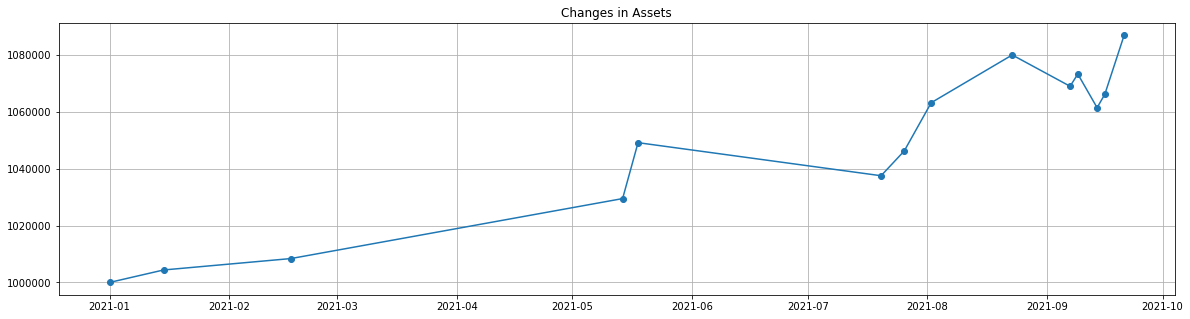

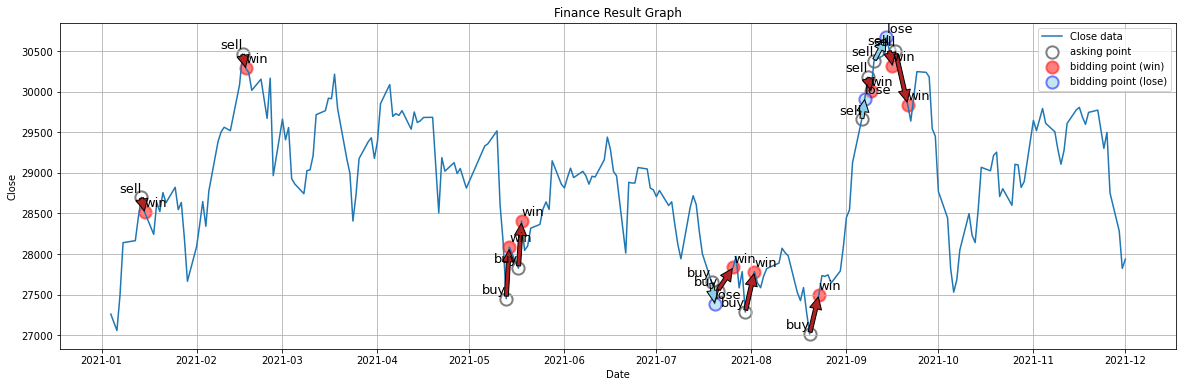

In [44]:
import warnings
warnings.simplefilter('ignore')
use_data = 'logic00018'
asset, cnt_win, cnt_lose, data_result = check_price(data_technical, use_data=use_data)
display(data_result)
data_plot_asset(data_result)
data_plot_info(data_technical, data_result, data_graph, use_data=use_data)